<a href="https://colab.research.google.com/github/mekabuko/DS_TIL/blob/main/Aidemy_Option/22_%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%E4%B8%89%E7%9B%AE%E4%B8%A6%E3%81%B9/22_%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%E4%B8%89%E7%9B%AE%E4%B8%A6%E3%81%B9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode: 100 (396 step), 21 wins, 18 draws, 61 loses
Episode: 200 (784 step), 17 wins, 21 draws, 62 loses
Episode: 300 (1192 step), 19 wins, 26 draws, 55 loses
Episode: 400 (1584 step), 29 wins, 19 draws, 52 loses
Episode: 500 (1980 step), 18 wins, 26 draws, 56 loses
Episode: 600 (2367 step), 15 wins, 16 draws, 69 loses
Episode: 700 (2759 step), 21 wins, 16 draws, 63 loses
Episode: 800 (3145 step), 13 wins, 18 draws, 69 loses
Episode: 900 (3543 step), 12 wins, 24 draws, 64 loses
Episode: 1000 (3921 step), 15 wins, 17 draws, 68 loses
Episode: 1100 (4311 step), 24 wins, 22 draws, 54 loses
Episode: 1200 (4702 step), 13 wins, 21 draws, 66 loses
Episode: 1300 (5089 step), 23 wins, 20 draws, 57 loses
Episode: 1400 (5498 step), 23 wins, 25 draws, 52 loses
Episode: 1500 (5900 step), 21 wins, 27 draws, 52 loses
Episode: 1600 (6287 step), 22 wins, 15 draws, 63 loses
Episode: 1700 (6688 step), 18 wins, 24 draws, 58 loses
Episode: 1800 (7084 step), 21 wins, 22 draws, 57 loses
Episode: 1900 (7474 s

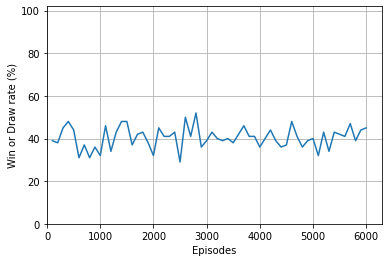

In [5]:
BATCH_SIZE = 32
NUM_REPLAY_MEMORY = 10000
INITIAL_REPLAY_SIZE = 5000
TRAIN_INTERVAL = 1
TARGET_UPDATE_INTERVAL = 10000
GAMMA = 0.99

import numpy as np
import random
from collections import deque

import copy
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

class Environment():    
    def start(self):
        self.Map = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0])
        return self.Map
    
    def terminal(self, Map, num_player):
        vhd = []
        for i in range(3):
            vhd.append(Map[i+0] * Map[i+3] * Map[i+6])
            vhd.append(Map[0+3*i] * Map[1+3*i] * Map[2+3*i])
        vhd.append(Map[0] * Map[4] * Map[8])
        vhd.append(Map[2] * Map[4] * Map[6])    
        vhd = np.array(vhd)
        vhd -= num_player**3
        done = (vhd.prod() == 0)
        return done 
    
    def step(self, action):
        reward = 0.0
        
        # Agentが打ちます
        self.Map[action] = 1
        done = self.terminal(self.Map, num_player=1) 
        
        # 先手(Agent)が勝ちの場合
        if done:
            reward = 1.0
        #「勝ちが決まらない」かつ「9マス埋まっている」場合、引き分けで終了
        elif self.Map.prod() != 0:
            reward = -0.5
            done = True
        # 先手が打って終了しなかった場合、Enermyが打ちます
        else:
            # get_action_Enemy関数から、actionを取得します
            action = self.get_action_Enemy(self.Map)
            self.Map[action] = 2
            done = self.terminal(self.Map, num_player=2) 
            if done:
                reward = -1.0
        return self.Map, reward, done
    
    def get_action_Enemy(self,Map):
        empty_Map_list = np.where(Map == 0)[0]
        
        if np.random.rand() <= 0.25:
            action = np.random.choice(empty_Map_list, 1)
        else:
            done_future_list1 = []
            done_future_list2 = []
            for j in range(len(empty_Map_list)):
                future_Map1 = np.copy(Map)
                future_Map2 = np.copy(Map)
                future_Map1[empty_Map_list[j]] = 1
                future_Map2[empty_Map_list[j]] = 2                
                done_future_list1.append(self.terminal(future_Map1,num_player=1))
                done_future_list2.append(self.terminal(future_Map2,num_player=2))
            done_future_list1 = np.array(done_future_list1)  
            done_future_list2 = np.array(done_future_list2) 
            
            if len(np.where(done_future_list2==True)[0]) > 0: 
                temp_list = np.where(done_future_list2 == True)[0]
                action = empty_Map_list[np.random.choice(temp_list)]
            elif len(np.where(done_future_list1==True)[0]) > 0: 
                temp_list = np.where(done_future_list1 == True)[0] 
                action = empty_Map_list[np.random.choice(temp_list)]
            else:
                action = np.random.choice(empty_Map_list, 1)
            
        return action

class QNet(chainer.Chain):

    def __init__(self, n_in, n_units, n_out):
        # Linear:全結合層 n_in個の入力からn_unitsの出力をします
        super(QNet, self).__init__(
            l1=L.Linear(n_in, n_units),    
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_out),
        )

    # 活性化関数の指定、reluはReLUのことです
    def value(self, x):
        h = F.relu(self.l1(x))  
        h = F.relu(self.l2(h))
        return self.l3(h)

    def __call__(self, s_data, a_data, y_data):
        self.loss = None

        s = chainer.Variable(np.asarray(s_data))
        Q = self.value(s)

        Q_data = copy.deepcopy(Q.data)

        if type(Q_data).__module__ != np.__name__:
            Q_data = np.asnumpy(Q_data)

        t_data = copy.deepcopy(Q_data)
        for i in range(len(y_data)):
            t_data[i, a_data[i]] = y_data[i]

        t = chainer.Variable(np.asarray(t_data))
        # 誤差関数:教師データと出力データの差の二乗平均
        self.loss = F.mean_squared_error(Q, t)

        return self.loss

class Agent():
    
    def __init__(self):
        # Replay Memory用データ
        self.replay_memory = deque()
        
        # Q_networkの初期化。層数は順に54→30→30→9となります
        self.Q = QNet(54, 30, 9)
        # targetQ_networkにQ_networkをコピーします
        self.targetQ = copy.deepcopy(self.Q)
        # 自動で誤差関数の計算と誤差逆伝搬による重み更新を行う、optimizerを設定します
        self.optimizer = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.0)
        # optimizerにQ_networkをセットします
        self.optimizer.setup(self.Q)
    
    def get_action(self,Map):
        # 空白取得
        empty_Map_list = np.where(Map == 0)[0]
        action = np.random.choice(empty_Map_list, 1)
        return action
    
    def run(self, state, action, reward, next_state, done):
        self.state = self.transform_state(state)
        self.next_state = self.transform_state(next_state)
        empty_Map = np.where(Map == 0)[0]
        
        # Replay Memory用データの保存
        self.replay_memory.append((self.state, action, reward, self.next_state, done, empty_Map))
        if len(self.replay_memory) > NUM_REPLAY_MEMORY:
            # .popleft : deque の左側から要素をひとつ削除し、その要素を返します
            self.replay_memory.popleft()
        
        if step >= INITIAL_REPLAY_SIZE:
            if step % TRAIN_INTERVAL == 0:
                # Q_networkの更新
                self.train_Q_network()
            if step % TARGET_UPDATE_INTERVAL == 0:
                # targetQ_networkの更新
                self.targetQ
        
    def transform_state(self, state):
        temp = np.copy(state)
        for k in range(27):
            # 0は00に分解する
            if temp[2*k] == 0:
                temp = np.insert(temp,2*k+1,0)
            # 1は01に分解する
            if temp[2*k] == 1:
                temp[2*k] = 0
                temp = np.insert(temp,2*k+1,1)
            # 2は10に分解する
            if temp[2*k] == 2:
                temp[2*k] = 1
                temp= np.insert(temp,2*k+1,0)
        return temp
        
    def train_Q_network(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        s2 = []
        done_batch = []
        y_batch = []
        empty_batch = []
        
        minibatch = random.sample(self.replay_memory, BATCH_SIZE)
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            s2.append(data[3])
            done_batch.append(data[4])
            empty_batch.append(data[5])
        # done=True/Falseを1/0に変換します
        done_batch = np.array(done_batch) + 0
        
        state_batch = np.array(state_batch, dtype=np.float32)
        #action_batch = np.array(reward_batch, dtype=np.int32)
        #reward_batch = np.array(reward_batch, dtype=np.float32)
        s2 = np.array(s2, dtype=np.float32)
        done_batch = np.array(done_batch, dtype=np.float32)
        
        s2 = chainer.Variable(s2)
        Q = self.targetQ.value(s2)
        targetQ_values_batch = Q.data
        
        # (注意) targetQ値のうち、選択可能なactionの中で最大のものを選びます
        # (注意) ここでは選択不可能な行動に対応するQ値から-10しています
        for n in range(32):
            for k in range(len(empty_batch[n])):
                targetQ_values_batch[n][empty_batch[n][k]] = -10.0 
        
        # (注意) targetQ値のうち、選択可能なactionの中で最大のものを選びます
        y_batch = reward_batch + (1 - done_batch) * GAMMA * np.max(targetQ_values_batch, axis=1)
        y_batch = np.array(y_batch).reshape(32,1)
        self.optimizer.update(self.Q, state_batch, action_batch, y_batch)

# 初期設定
random.seed(0)
np.random.seed(1)
episodes = 6000
result_interval= 100
total_win, total_draw, total_lose = 0,0,0

# インスタンス作成
env=Environment()
agent=Agent()

#グラフ用のデータ格納リストを宣言
episodes_list = []
win_or_draw_list = []

step = 1
for num_episode in range(episodes):
    Map = env.start()
    state = np.append(Map,Map,axis=0)
    state = np.append(state,Map,axis=0)
    done = False
    
    while not done:
        action = agent.get_action(Map)
        new_Map,reward,done = env.step(action)
        next_state = np.append(state[9:27],new_Map,axis=0)
        # データの蓄積、Q_networkの更新、targetQ_networkの更新
        agent.run(state,action,reward,next_state,done)
        Map = np.copy(new_Map)
        state = np.copy(next_state)
        step += 1
        
    # 結果を記録するための処理です
    if reward == 1.0:
            total_win += 1
    elif reward == -0.5:
            total_draw += 1
    elif reward == -1.0:
            total_lose += 1
    
    if (num_episode+1)%result_interval == 0:
        print('Episode: {} ({} step), {} wins, {} draws, {} loses'.format((num_episode+1), step, total_win, total_draw, total_lose))
        
        # ファイルに出力
        with open('result.txt', 'a') as f:
            f.writelines('Episode: {}, {} wins, {} draws, {} loses'.format((num_episode+1), total_win, total_draw, total_lose) + '\n')
        #グラフ用のデータを保存
        episodes_list.append(num_episode+1)
        win_or_draw_list.append((total_win+total_draw)/result_interval*100)
        # 変数をリセット
        total_win, total_draw, total_lose = 0,0,0
        
# 学習結果をグラフで出力
plt.plot(np.asarray(episodes_list), np.asarray(win_or_draw_list))
plt.xlabel('Episodes')
plt.ylabel('Win or Draw rate (%)')
plt.xlim(0,)
plt.ylim(0,102)
plt.grid(True)

plt.savefig("result.png")

## ε-greedy 法の実装版

Episode: 100 (395 step), 19 wins, 22 draws, 59 loses
Episode: 200 (784 step), 17 wins, 19 draws, 64 loses
Episode: 300 (1185 step), 16 wins, 26 draws, 58 loses
Episode: 400 (1583 step), 21 wins, 22 draws, 57 loses
Episode: 500 (1967 step), 25 wins, 17 draws, 58 loses
Episode: 600 (2358 step), 16 wins, 23 draws, 61 loses
Episode: 700 (2745 step), 18 wins, 16 draws, 66 loses
Episode: 800 (3139 step), 29 wins, 16 draws, 55 loses
Episode: 900 (3526 step), 21 wins, 18 draws, 61 loses
Episode: 1000 (3926 step), 15 wins, 26 draws, 59 loses
Episode: 1100 (4311 step), 13 wins, 23 draws, 64 loses
Episode: 1200 (4712 step), 22 wins, 27 draws, 51 loses
Episode: 1300 (5108 step), 19 wins, 23 draws, 58 loses
Episode: 1400 (5500 step), 22 wins, 16 draws, 62 loses
Episode: 1500 (5896 step), 25 wins, 21 draws, 54 loses
Episode: 1600 (6286 step), 19 wins, 20 draws, 61 loses
Episode: 1700 (6664 step), 22 wins, 16 draws, 62 loses
Episode: 1800 (7056 step), 15 wins, 22 draws, 63 loses
Episode: 1900 (7437 s

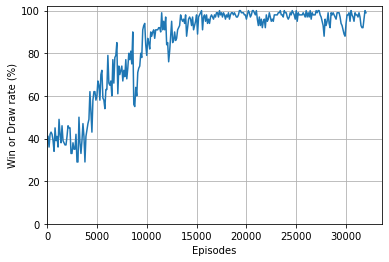

In [6]:
import numpy as np
import random
from collections import deque

import copy
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

class Environment():    
    def start(self):
        self.Map = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0])
        return self.Map
    
    def terminal(self, Map, num_player):
        vhd = []
        for i in range(3):
            vhd.append(Map[i+0] * Map[i+3] * Map[i+6])
            vhd.append(Map[0+3*i] * Map[1+3*i] * Map[2+3*i])
        vhd.append(Map[0] * Map[4] * Map[8])
        vhd.append(Map[2] * Map[4] * Map[6])    
        vhd = np.array(vhd)
        vhd -= num_player**3
        done = (vhd.prod() == 0)
        return done 
    
    def step(self, action):
        reward = 0.0
        
        # Agentが打ちます
        self.Map[action] = 1
        done = self.terminal(self.Map, num_player=1) 
        
        # 先手(Agent)が勝ちの場合
        if done:
            reward = 1.0
        #「勝ちが決まらない」かつ「9マス埋まっている」場合、引き分けで終了
        elif self.Map.prod() != 0:
            reward = -0.5
            done = True
        # 先手が打って終了しなかった場合、Enermyが打ちます
        else:
            # get_action_Enemy関数から、actionを取得します
            action = self.get_action_Enemy(self.Map)
            self.Map[action] = 2
            done = self.terminal(self.Map, num_player=2) 
            if done:
                reward = -1.0
        return self.Map, reward, done
    
    def get_action_Enemy(self,Map):
        empty_Map_list = np.where(Map == 0)[0]
        
        if np.random.rand() <= 0.25:
            action = np.random.choice(empty_Map_list, 1)
        else:
            done_future_list1 = []
            done_future_list2 = []
            for j in range(len(empty_Map_list)):
                future_Map1 = np.copy(Map)
                future_Map2 = np.copy(Map)
                future_Map1[empty_Map_list[j]] = 1
                future_Map2[empty_Map_list[j]] = 2                
                done_future_list1.append(self.terminal(future_Map1,num_player=1))
                done_future_list2.append(self.terminal(future_Map2,num_player=2))
            done_future_list1 = np.array(done_future_list1)  
            done_future_list2 = np.array(done_future_list2) 
            
            if len(np.where(done_future_list2==True)[0]) > 0: 
                temp_list = np.where(done_future_list2 == True)[0]
                action = empty_Map_list[np.random.choice(temp_list)]
            elif len(np.where(done_future_list1==True)[0]) > 0: 
                temp_list = np.where(done_future_list1 == True)[0] 
                action = empty_Map_list[np.random.choice(temp_list)]
            else:
                action = np.random.choice(empty_Map_list, 1)
            
        return action

class QNet(chainer.Chain):

    def __init__(self, n_in, n_units, n_out):
        # Linear:全結合層 n_in個の入力からn_unitsの出力をします
        super(QNet, self).__init__(
            l1=L.Linear(n_in, n_units),    
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_out),
        )

    # 活性化関数の指定、reluはReLUのことです
    def value(self, x):
        h = F.relu(self.l1(x))  
        h = F.relu(self.l2(h))
        return self.l3(h)

    def __call__(self, s_data, a_data, y_data):
        self.loss = None

        s = chainer.Variable(np.asarray(s_data))
        Q = self.value(s)

        Q_data = copy.deepcopy(Q.data)

        if type(Q_data).__module__ != np.__name__:
            Q_data = np.asnumpy(Q_data)

        t_data = copy.deepcopy(Q_data)
        for i in range(len(y_data)):
            t_data[i, a_data[i]] = y_data[i]

        t = chainer.Variable(np.asarray(t_data))
        # 誤差関数:教師データと出力データの差の二乗平均
        self.loss = F.mean_squared_error(Q, t)

        return self.loss

class Agent():
    
    def __init__(self):
        # Replay Memory用データ
        self.replay_memory = deque()
        
        # Q_networkの初期化。層数は順に54→30→30→9となります
        self.Q = QNet(54, 30, 9)
        # targetQ_networkにQ_networkをコピーします
        self.targetQ = copy.deepcopy(self.Q)
        # 自動で誤差関数の計算と誤差逆伝搬による重み更新を行う、optimizerを設定します
        self.optimizer = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.0)
        # optimizerにQ_networkをセットします
        self.optimizer.setup(self.Q)
    
    def get_action(self,Map):
        # 空白取得
        empty_Map_list = np.where(Map == 0)[0]
        
        if step < INITIAL_REPLAY_SIZE:
            self.epsilon = INITIAL_EPSILON
        elif step < (INITIAL_REPLAY_SIZE + EXPLORATION_STEPS):
            self.epsilon -= epsilon_step
        elif step >= (episodes - 1000):
            self.epsilon = -1.0 
        
        temp_random = np.random.rand()
        if temp_random <= self.epsilon:
            action = np.random.choice(empty_Map_list, 1)
        if temp_random > self.epsilon:
            self.temp_state = self.transform_state(state)
            self.temp_state = self.temp_state.reshape(1,54)
            
            self.temp_state = np.asarray(self.temp_state).astype(np.float32)
            s = chainer.Variable(np.asarray(self.temp_state))
            Qs = self.Q.value(s)
            Qs_list = Qs.data[0]
            Q_list = np.array(Qs_list)

            Q_able_list = []
            for m in range(len(empty_Map_list)):
                Q_able_list.append(Q_list[empty_Map_list[m]])
            max = np.max(Q_able_list)
            action_list = np.where(Q_list==max)[0]
            action = np.random.choice(action_list, 1)
        
        return action
    
    def run(self, state, action, reward, next_state, done):
        self.state = self.transform_state(state)
        self.next_state = self.transform_state(next_state)
        empty_Map = np.where(Map == 0)[0]
        
        # Replay Memory用データの保存
        self.replay_memory.append((self.state, action, reward, self.next_state, done, empty_Map))
        if len(self.replay_memory) > NUM_REPLAY_MEMORY:
            # .popleft : deque の左側から要素をひとつ削除し、その要素を返します
            self.replay_memory.popleft()
            
        if step >= INITIAL_REPLAY_SIZE:
            if step % TRAIN_INTERVAL == 0:
                # Q_networkの更新
                self.train_Q_network()
            if step % TARGET_UPDATE_INTERVAL == 0:
                # targetQ_networkの更新
                self.targetQ
        
    def transform_state(self, state):
        temp = np.copy(state)
        for k in range(27):
            # 0は00に分解する
            if temp[2*k] == 0:
                temp = np.insert(temp,2*k+1,0)
            # 1は01に分解する
            if temp[2*k] == 1:
                temp[2*k] = 0
                temp = np.insert(temp,2*k+1,1)
            # 2は10に分解する
            if temp[2*k] == 2:
                temp[2*k] = 1
                temp= np.insert(temp,2*k+1,0)
        return temp
        
    def train_Q_network(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        s2 = []
        done_batch = []
        y_batch = []
        empty_batch = []
        
        minibatch = random.sample(self.replay_memory, BATCH_SIZE)
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            s2.append(data[3])
            done_batch.append(data[4])
            empty_batch.append(data[5])
        # done=True/Falseを1/0に変換します
        done_batch = np.array(done_batch) + 0
        
        state_batch = np.array(state_batch, dtype=np.float32)
        #action_batch = np.array(reward_batch, dtype=np.int32)
        #reward_batch = np.array(reward_batch, dtype=np.float32)
        s2 = np.array(s2, dtype=np.float32)
        done_batch = np.array(done_batch, dtype=np.float32)
        
        s2 = chainer.Variable(s2)
        Q = self.targetQ.value(s2)
        targetQ_values_batch = Q.data
        
        # (注意) targetQ値のうち、選択可能なactionの中で最大のものを選びます
        # (注意) ここでは選択不可能な行動に対応するQ値から-10しています
        for n in range(32):
            for k in range(len(empty_batch[n])):
                targetQ_values_batch[n][empty_batch[n][k]] = -10.0 
        
        # (注意) targetQ値のうち、選択可能なactionの中で最大のものを選びます。
        y_batch = reward_batch + (1 - done_batch) * GAMMA * np.max(targetQ_values_batch, axis=1)
        y_batch = np.array(y_batch).reshape(32,1)
        self.optimizer.update(self.Q, state_batch, action_batch, y_batch)
        
# 初期設定
random.seed(0)
np.random.seed(1)
episodes = 32000
result_interval= 100
total_win, total_draw, total_lose = 0,0,0
BATCH_SIZE = 32
NUM_REPLAY_MEMORY = 10000
INITIAL_REPLAY_SIZE = 5000
TRAIN_INTERVAL = 1
TARGET_UPDATE_INTERVAL = 10000
GAMMA = 0.99
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
EXPLORATION_STEPS = 10000
epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS

# インスタンス作成
env=Environment()
agent=Agent()

#グラフ用のデータ格納リストを宣言
episodes_list = []
win_or_draw_list = []

step = 1
for num_episode in range(episodes):
    Map = env.start()
    state = np.append(Map,Map,axis=0)
    state = np.append(state,Map,axis=0)
    done = False
    
    while not done:
        action = agent.get_action(Map)
        new_Map,reward,done = env.step(action)
        next_state = np.append(state[9:27],new_Map,axis=0)
        # データの蓄積、Q_networkの更新、targetQ_networkの更新
        agent.run(state,action,reward,next_state,done)
        Map = np.copy(new_Map)
        state = np.copy(next_state)
        step += 1
        
    # 結果を記録するための処理です
    if reward == 1.0:
            total_win += 1
    elif reward == -0.5:
            total_draw += 1
    elif reward == -1.0:
            total_lose += 1
    
    if (num_episode+1)%result_interval == 0:
        print('Episode: {} ({} step), {} wins, {} draws, {} loses'.format((num_episode+1), step, total_win, total_draw, total_lose))
        
        # ファイルに出力
        with open('result.txt', 'a') as f:
            f.writelines('Episode: {}, {} wins, {} draws, {} loses'.format((num_episode+1), total_win, total_draw, total_lose) + '\n')
        #グラフ用のデータを保存
        episodes_list.append(num_episode+1)
        win_or_draw_list.append((total_win+total_draw)/result_interval*100)
        # 変数をリセット
        total_win, total_draw, total_lose = 0,0,0
        

# 学習結果をグラフで出力
plt.plot(np.asarray(episodes_list), np.asarray(win_or_draw_list))
plt.xlabel('Episodes')
plt.ylabel('Win or Draw rate (%)')
plt.xlim(0,)
plt.ylim(0,102)
plt.grid(True)

plt.savefig("result.png")